In [11]:
module FractionalFokkerMixed

using LinearAlgebra
using Printf
using GradientRobustMultiPhysics
using ExtendableGrids
using GridVisualize
using ExtendableSparse
using SpecialFunctions

"""
    get_problem_data(ν)

TBW
"""
function get_problem_data(ϵ, p=1, α=1.0)
    γ= DataFunction([0.0]; name = "γ")    
    function coeffbeta!(result, x, t)
        result[1] = x[1];
        result[2] = x[2];
    end    
    β = DataFunction(coeffbeta!, [2,2]; name="β", dependencies="XT", bonus_quadorder=1)
    function exact!(result, x, t)
        result[1] = (x[1]-x[1]^2)*(x[2]-x[2]^2)*(1.0+t);
    end    
    u = DataFunction(exact!, [1,2]; name="u", dependencies="XT", bonus_quadorder=5)
    dt_u = eval_dt(u)
    ∇u = eval_∇(u)
    Δu = eval_Δ(u)
    function rhs!(result, x, t)    
        # dt_u = x[1]*(1-x[1])*x[2]*(1-x[2])*gamma(p+1)/gamma(p-α+1)*t^(p-α) 
        u = (x[1]-x[1]^2)*(x[2]-x[2]^2)*(1.0+t);
        ux = (1-2*x[1])*(x[2]-x[2]^2)*(1.0+t);
        uxx = -2*(x[2]-x[2]^2)*(1.0+t);
        uy = (x[1]-x[1]^2)*(1-2*x[2])*(1.0+t); 
        uyy = -2*(x[1]-x[1]^2)*(1.0+t);
        ut = (x[1]-x[1]^2)*(x[2]-x[2]^2);
        result[1] = ut - (uxx+uyy) + x[1]*ux+x[2]*uy + 2*u;
      return nothing
    end
    f = DataFunction(rhs!, [1,2]; name = "f", dependencies = "XT", bonus_quadorder = 5)  

    return γ, β, u, ∇(u), f
end

function main(;ϵ=1.0, nrefinements=2, nsteps=10, T0=0, Tf=1.0, α=1, tpower=1.0, verbosity=0)
    ## finite elements and bilinear forms
    # Prepare the matrices and rhs coming from space discretization 
    ## set log level
    set_verbosity(verbosity)    
    # choose a finite element type
    # FEType = [H1P1{1}, HDIVRT1{2}]
    FEType = [L2P0{1}, HDIVRT0{2}]
    ## load initial mesh
    #xgrid = grid_unitsquare(Triangle2D)
    xgrid = uniform_refine(grid_unitsquare(Triangle2D), nrefinements)
    FES = [FESpace{FEType[1]}(xgrid; broken = true), FESpace{FEType[2]}(xgrid)]
    ## negotiate data functions to the package
    γ, β, u, ∇u, f = get_problem_data(ϵ, tpower, α)

    function convection_kernel(result, input, x, t)
        # evaluate β        
        eval_data!(β, x, t)
        # compute β ⋅ \sigma
            result[1] = 0.0
            result[2] = 0.0
        for k = 1 : 2
            result[k] += β.val[k]*input[1]
        end
    end
    action = Action(convection_kernel, [2, 1]; dependencies = "XT", bonus_quadorder = β.bonus_quadorder) 
    CO = BilinearForm([Identity, Identity], action; factor = -1/ϵ, transposed_assembly = false, apply_action_to=[2])

    # @show FES
    Solution = FEVector(FES)
    n_dofs = FES[1].ndofs + FES[2].ndofs
    interpolate!(Solution[1], u; time = 0.0)
    #@show Solution
    
    # matrices 
    M = FEMatrix(FES)
    assemble_operator!(M[1,1], BilinearForm([Identity, Identity]))
    # @show M.entries
    # println(size(M[1,1]))
    #println("ndofs: ", FES[1].ndofs)
    A = FEMatrix(FES)    
    rhs = FEVector(FES)
    
    t0 = T0
    tau = (Tf - T0)/nsteps
    @show nrefinements, nsteps

    V1 = zeros(Float64, FES[1].ndofs+FES[2].ndofs, 1)
    #V1 = FEVector(FES)
    Mu0 = zeros(Float64, FES[1].ndofs+FES[2].ndofs)

    SystemMatrix = FEMatrix(FES)
    # @show SystemMatrix
    SystemRHS = FEVector(FES)
    SystemSol = FEVector(FES)
    # time loop
    l2u = zero(Float64); h1u = zero(Float64)
    l2sig = zero(Float64); oldl2sig=zero(Float64)
    eL2sig = zero(Float64)
    oldL2u = zero(Float64); oldh1u = zero(Float64)
    eL2u = zero(Float64); eh1u = zero(Float64)
    
    for m = 2:nsteps
        t0 = t0 + tau        
        # assemble rhs 
        fill!(SystemRHS.entries, 0)
        fill!(rhs.entries, 0)
        assemble_operator!(rhs[1], LinearForm(Identity, f; factor = 1.0); time=t0)
        assemble_operator!(rhs[2], LinearForm(NormalFlux, u; AT=ON_BFACES, factor = -1); time=t0)
        V1[:, 1] = rhs.entries

        fill!(SystemMatrix.entries.cscmatrix.nzval, 0)
        fill!(A.entries.cscmatrix.nzval, 0)
        # assembling the matrices with coefficients depending on time     
        assemble_operator!(A[1,1], ReactionOperator(γ); time=t0)
        assemble_operator!(A[2,1], BilinearForm([Divergence, Identity]; factor = -1.0)) 
        assemble_operator!(A[1,2], BilinearForm([Identity, Divergence]; factor =  1.0))        
        assemble_operator!(A[2,2], BilinearForm([Identity, Identity]; factor = 1/ϵ))
        assemble_operator!(A[2,1], CO; time = t0)
        
        addblock!(SystemMatrix[1, 1], M[1, 1]; factor= 1.0/tau)
        addblock!(SystemMatrix[1, 1], A[1, 1]; factor= 1.0)
        addblock!(SystemMatrix[1, 2], A[1, 2]; factor= 1.0)
        addblock!(SystemMatrix[2, 1], A[2, 1]; factor= 1.0)
        addblock!(SystemMatrix[2, 2], A[2, 2]; factor= 1.0)
        #@info "Preparing the rhs with right coefficients"
        # rhs at current time 
        addblock!(SystemRHS[1], V1[:,1]; factor= 1.0 )
        # 1/tau^α * ∑ ω_j^α M u^0 
        # addblock!(SystemRHS[1], Mu0; factor= sum_omega[m]/scale)
        Mu0[:] = M.entries*Solution.entries
        addblock!(SystemRHS[1], Mu0; factor= 1.0/tau)
        
        flush!(SystemMatrix.entries)      
        #@show SystemRHS.entries
        Solution.entries[:] = SystemMatrix.entries \ SystemRHS.entries        

        L2Error_u = L2ErrorIntegrator(u, Identity; time= t0)
        l2u = evaluate(L2Error_u, Solution[1])
        eL2u += (l2u + oldL2u) * tau * 0.5
        oldL2u = l2u
        h1u = L2ErrorIntegrator(∇u, Gradient; time= t0)
        h1u = evaluate(h1u, Solution[1])
        eh1u += (h1u + oldh1u) * tau * 0.5
        oldh1u = h1u

        function error_kernel(result, input, x)
            # evaluate β        
            eval_data!(β, x, t0)
            eval_data!(∇u, x, t0)
            # compute β ⋅ \sigma
                result[1] = 0.0                
            for k = 1 : 2
                result[1] += (input[1+k]-β.val[k]*input[1] + ∇u.val[k])^2
            end
        end
        action = Action(error_kernel, [1, 3]; dependencies = "X", bonus_quadorder = β.bonus_quadorder) 
        l2error_sigma = ItemIntegrator([Identity, Identity], action)        
        l2sig = evaluate(l2error_sigma, [Solution[1], Solution[2]])
        eL2sig += (l2sig + oldl2sig) * tau * 0.5
        oldl2sig = l2sig

        # @show sqrt(l2), sqrt(h1)
    end
    @show (sqrt(l2u), sqrt(h1u), sqrt(l2sig), sqrt(eL2u), sqrt(eh1u), sqrt(eL2sig))
    (sqrt(l2u), sqrt(h1u), sqrt(l2sig), sqrt(eL2u), sqrt(eh1u), sqrt(eL2sig))
end

end

Main.FractionalFokkerMixed

In [12]:
ns = [1 2 3 4 5]
eL2u=[]; eH1u=[]; eL2S=[];  
for n in ns
    el2u, eh1u, el2s = Main.FractionalFokkerMixed.main(nrefinements=n, nsteps=20, α=1.0, tpower=1)
    push!(eL2u, el2u)
    push!(eH1u, eh1u)
    push!(eL2S, el2s)
end

L2u: Any[0.0190847082541284, 0.009302974814694151, 0.00461666044975683, 0.0023038408073287435, 0.0011513549782940487]
L2s: Any[0.12010844180323306, 0.06731344950246466, 0.03452620224259377, 0.017370651825094483, 0.008698736046453864]


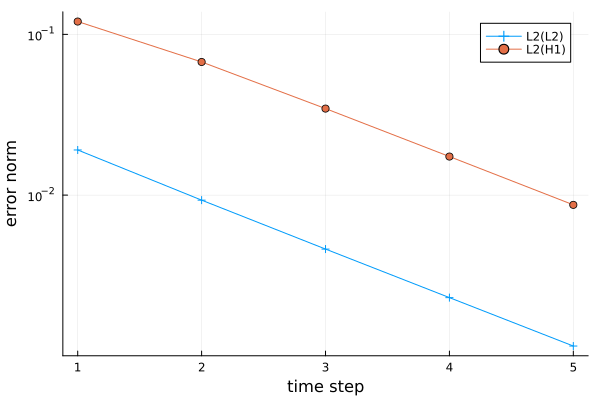

In [10]:
using Plots
println("L2u: ", eL2u)
println("L2s: ", eL2S)
taus = [ 1, 2, 3, 4, 5]
plot(taus,[eL2u eL2S],
    yaxis=:log10,
    label=["L2(L2)" "L2(H1)" "L2(L2)"],
    shape=:auto,
    xlabel="time step",ylabel="error norm")